<a href="https://colab.research.google.com/github/scolloms/Leiden-Workshop-Flows/blob/main/Flows_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 17/10/2024 - An interactive guide to Conditional Normalising Flows
## Leiden Workshop 2024

Author: Storm Colloms (University of Glasgow)

Email: s.colloms.1@research.gla.ac.uk

Last editted: 08-10-24

![flow (blue) learns population of binary black holes (orange)](flow_learning_mchirp_0924.gif)

**Figure 1:** An animation of a normalising flow (blue) learning the orange distribution (the chirp masses of a simulated population of BBHs). The flow starts training without having optimised the series of transforms, and thus looks very Gaussian. During training, the flow improves its ability to distinguish features in the target distribution.

#Introduction to Normalising Flows
**Normalising Flows** are a type of algorithm built from simple neural networks that can be trained to emulate **probability distributions**. They do this by learning a series of **invertible transforms** which can map the target distribution to a **latent space** and vice versa.

This latent space is often chosen to be an n-dimensional Gaussian, hence the algorithm *flows* the target distribution through a series of *normalising* transforms.

Because this latent space is easy to sample from (because it is easy to compute the CDF in the latent space), by knowing the latent space and the invertible transforms to go from latent to target space, it is then easy to sample additional points from the target distribution. Additionally, the value of the distribution is easy to calculate in the latent space and then map to the latent space, therefore the value of the target distribution is easy to calculate with a flow, even if that area of parameter space has not previously been sampled from. Therefore, flows are often used to emulate distributions which are hard to sample from, or don't have an analytic form but knowing the value of the distribution at any point is necessary.


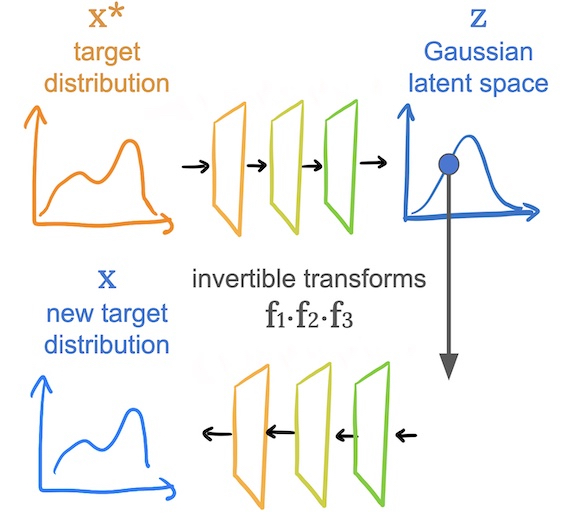

## Mathematical definition

### Transforming Distributions
For a single transformation $f$, where the target distribution $x$ relates to the latent distribution $z$ as $z=f(x)$, the relationship between the target, $p_{x}(x)$, and latent, $p_{z}(f(x))$,  distributions is

$$
p_{x}(x) = p_{z}(f(x)) \left| \frac{\partial f(x)}{\partial x}\right|.
$$

The defining feature of a normalising flow is that the Jacobian of the transformation $|{\partial f(x)}/{\partial x}|$ is easily computed (tractable), and that the function $f$ is invertible.

In reality the flow can learn an arbritrary series of N transforms,

$$
z=f_N\cdot\cdot \cdot f_2 \cdot f_1(x).
$$

The objective of the normalising flow is to get the transformed target samples as close to a true Gaussian by optimising this series of transforms. Conversely, its objective is to get the emulated distribution, $p_{x}(x)$, to resemble the true target distribution, $p^{*}_{x}(x)$, as closely as possible.

### KL-Divergence

To measure how close the emulated distribution is to the target requires a distance measurement between these two distributions. This distance is the **loss metric** used when training a normalising flow.

The most commonly used distance metric is the Kullback–Leibler (KL) divergence. This is a non-symmetric distance measure between 2 distributions. For the KL divergence from the true target distribution $p^{*}_{x}(x)$ to the emulated distribution from the flow and $p_{x}(x)$ this is

$$
D_{\mathrm{KL}}[p_x^*(x)|| p_x(x)] =\int_{-\infty}^{+\infty} p_x^*(x) \ln (\frac{p_x^*(x)}{p_x(x)}) \mathrm{d} x  \\
=-\int_{-\infty}^{+\infty} p_x^*(x) \ln \left(p_x(x)\right) \mathrm{d} x+\text { const. } \\
=  -\mathbb{E}_{p_x^*(x)}\left[\ln p_x(x)\right]+\text { const. } \\
=-\mathbb{E}_{p_x^*(x)}\left[\ln p_z(f(x))+\ln \left|\operatorname{det} \frac{\partial f(x )}{\partial x}\right|\right]+\text { const. }.
$$

Let's assume we have $K$ samples from our target distribution but not a functional form. Then we can estimate the expectation over $p^{*}_{x}(x)$ by a Monte-carlo sum, giving the loss funciton equal to

$$
\mathrm{Loss} \approx-\frac{1}{K} \sum_{k=1}^K \ln p_z(f(x))+\ln \left|\operatorname{det} \frac{\partial f(x)}{\partial x}\right|.
$$

### Conditional Flows

Flows are also powerful in that they can learn not only single distributions, but distributions conditional on some other parameter. For samples from some conditional distribution $p^{*}_{x}(x|A)$, where $A$ can vary with each $x$, normalising flows can emulate $p_x(x|A)$ for any value of $A$. In other words, flows can **interpolate** between any conditional values present in the data. Giving the flow the value of this conditional parameter when asking for samples or probability from the flow allows for this interpolation.

This is useful for applications in hierarchical inference, where the flow is used to emulate $p_x(x|A)$ before inference on parameter $A$.

## Further Reading

### Tutorials


*   [Two Moons Flows - Michael Williams](https://colab.research.google.com/github/phas-ml/phas-ml.github.io/blob/master/notebooks/2021_02_10_normalising_flows_tutorial.ipynb#scrollTo=r99VhqAPgqO_)
*   [Parabola Flows - Federico Stachurski](https://colab.research.google.com/drive/1lTXjGN2IfbfNt4P3AIV9U1PffEvIfHFd#scrollTo=hMY40_KDmp5f)


### Blog Posts
* [Normalizing Flows by Adam Kosiorek](http://akosiorek.github.io/ml/2018/04/03/norm_flows.html)
* [Flow-based Deep Generative Models by Lilian Weng](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)

### Papers

* [Normalizing Flows for Probabilistic Modeling and Inference](https://arxiv.org/abs/1912.02762)
* [Normalizing Flows: An Introduction and Review of Current Methods](https://arxiv.org/abs/1908.09257)
* [Neural Spline Flows](https://arxiv.org/abs/1906.04032)

# Example: Emulating Hertzsprung–Russel Diagrams of Globular Clusters

This example shows the training of a normalising flow on Globular Cluster (GC) data from the [Gaia](https://www.cosmos.esa.int/web/gaia) survey. The Gaia spacecraft launched in 2013 with the objective of creating the largest and most precise 3D space catalogue, mostly recording stellar astrometry.

Today we will use the temperature and luminosity measurements for stars in 5 GCs from Gaia's third data release and use these to emulate Hertzsprung–Russel Diagrams of GCs, conditional on the cluster's age.

## Imports

In [ ]:
!pip install glasflow astropy astroquery==0.4.6

#Imports
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
import seaborn as sns
from  glasflow import RealNVP, CouplingNSF
import pandas as pd
import matplotlib.cm as cm
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from sklearn.model_selection import train_test_split

sns.set_theme('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
torch.set_num_threads(1)

#Setting the random seed
seed =  1239
np.random.seed(seed)
torch.random.manual_seed(seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.9/888.9 kB 56.8 MB/s eta 0:00:00


## Reading Gaia Data

The GCs were identified with [Gaia EDR3 view on Galactic globular clusters](https://arxiv.org/abs/2102.09568) and the ages and metallicities were identitfied from  [Accreted versus in situ Milky Way globular clusters](https://academic.oup.com/mnras/article/404/3/1203/1049211).

In [ ]:
# Initialise a dictionary with the GC properties - names, locations, ages, metallicities, rough calculation of their radii.

GCs = np.array([{'name':'M5', 'ra':229.638, 'dec':2.081, 'age(Gyr)':10.62, 'Fe/H':-1.12, 'rad':0.4},\
    {'name':'M10', 'ra':254.288, 'dec':-4.100, 'age(Gyr)':11.39, 'Fe/H':-1.25, 'rad':0.3},\
    {'name':'NGC 4372', 'ra':186.439, 'dec':-72.659, 'age(Gyr)':12.54, 'Fe/H':-1.88}])

In [ ]:
#Search in a cone around the location of the GCs and read in the Gaia measurements avaliable for each cluster.
#The higher the Gaia row limit the longer this will take

Gaia.ROW_LIMIT = 100000

gaia_data = []

for GC in GCs:
    coord = SkyCoord(ra=GC['ra'], dec=GC['dec'], unit=(u.degree, u.degree), frame='icrs')
    k = Gaia.cone_search_async(coord, radius=u.Quantity(.5, u.deg))
    gaia_data.append(k.get_results())

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


Text(0, 0.5, 'log(L) / L$_\\odot$')

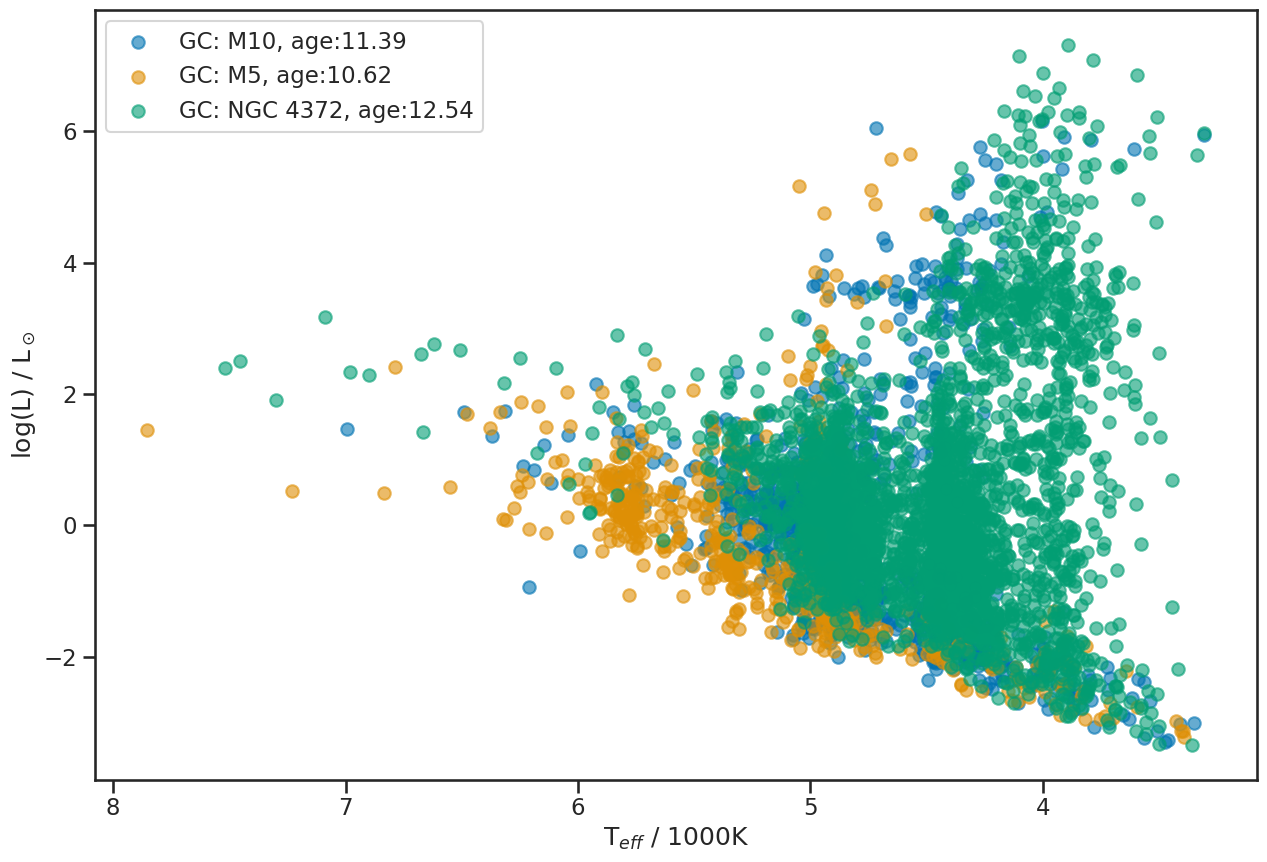

In [ ]:
fig = plt.figure(figsize=(15,10))

#initial array for total data set - this will be array containing all the temperatures, luminosities,
#and the associated cluster ages for each data sample.
GCs_data_red =np.zeros((0,3))
data_red_all = []

#Loop over the clusters again
for i, array in enumerate(gaia_data):
    #we need just the effective temperature and luminosities for the data
    teff= np.array(array['teff_val'])
    lum = np.array(array['lum_val'])
    data = np.stack([teff,lum], axis=-1)

    #keep only the data with both temperatiture and luminosity measurements, this becomes our reduced data set
    notnan_inxs=np.logical_and(~np.isnan(data[:,0]),~np.isnan(data[:,1]))
    data_red=data[notnan_inxs,:]

    #for optimal training, the data is reparametrised so it can already resemble a Gaussian and the
    #spread of the data is similar across the parameter space. Here we scale the temperature by a factor of 1000,
    #and instead learn the log luminosity.
    data_red[:,0] = data_red[:,0]/1000
    data_red[:,1] = np.log(data_red[:,1])

    #repeat values of age and metallicity to match the length of data_red for each cluster
    conditionals = np.repeat(np.array([[GCs[i]['age(Gyr)']]]), np.shape(data_red)[0], axis=0)

    #stack data and conditionals next to eachother
    data_red_conditionals = np.hstack([data_red,conditionals])
    GCs_data_red = np.append(GCs_data_red, data_red_conditionals, axis=0)
    data_red_all.append(data_red_conditionals)

    #Plot HR for each GC
    GC_name =GCs[i]['name']
    GC_age = GCs[i]['age(Gyr)']
    GC_met = GCs[i]['Fe/H']
    plt.scatter(data_red[:,0], data_red[:,1], label=f'GC: {GC_name}, age:{GC_age}', alpha=0.6)

plt.legend()
plt.gca().invert_xaxis()
plt.xlabel(r'T$_{eff}$ / 1000K')
plt.ylabel(r'log(L / L$_\odot$)')

We now have an array (`GCs_data_red`) that contains all the data from the Gaia query that contained temperature and luminosity measurements for the 3 GCs in question.

The rows in this array are each data point while the columns are in order Effective Temperature/1000, Log Luminosity, and the age of the associated GC:

In [ ]:
GCs_data_red

array([[ 4.68575001,  2.16731215, 11.39      ],
       [ 4.24800014,  5.55359697, 11.39      ],
       [ 4.87375021,  1.34915721, 11.39      ],
       ...,
       [ 4.80061007,  1.96919   , 12.54      ],
       [ 4.26800013, -1.59904027, 12.54      ],
       [ 4.24466658, -1.70143831, 12.54      ]])

## Splitting up training and validaiton sets

To train the flow we need training and validation data sets. The training data is manipulated during training to optimise the transforms learned by the flow, while the validation set is used at each epoch of training to evaluate the flow's performance.

Since we are using the `glasflows` package (which is a wrapper for `nflows`) which is based on `pytorch`, we will return all of our training and validation data as torch tensors.


In [ ]:
#Creating arrays of training data and validation data - shuffle split between all available data

train_data_stack, validation_data_stack = \
        train_test_split(GCs_data_red, shuffle=True, train_size=0.8)
batch_size = 100

In [ ]:
#Defining arrays to return torch tensors of the training and validation data with associated conditional values

def get_training_data(train_data):
        """
        Get random batch training data from a set of training data

        Returns
        -------
        xdata : tensor
            [no_samples, no_params]
        xconds : tensor
            [no_samples, no_conditionals]

        """
        #random choice of indices, used to get a random batch from train_data of length batch_size
        random_samples = np.random.choice(np.shape(train_data)[0],size=(int(batch_size)))
        train_batch = train_data[random_samples,:2]
        train_conds = train_data[random_samples,-1]

        #change data and conditionals to be torch tensors of correct shape
        xdata=torch.from_numpy(train_batch.astype(np.float32))
        xconds = torch.from_numpy(train_conds.astype(np.float32))
        xconds = xconds.reshape(-1,1)
        return(xdata, xconds)

def get_val_data(val_data):
        """
        Get random batch validation data from a set of validation data

        Returns
        -------
        xdata : tensor
            [no_samples, no_params]
        xconds : tensor
            [no_samples, no_conditionals]

        """
        #random choice of indices, used to get a random batch from val_data of length batch_size
        random_samples = np.random.choice(np.shape(val_data)[0],size=(int(batch_size)))
        val_batch = val_data[random_samples,:2]
        val_conds = val_data[random_samples,-1]

        #change data and conditionals to be torch tensors of correct shape
        xdata=torch.from_numpy(val_batch.astype(np.float32))
        xconds = torch.from_numpy(val_conds.astype(np.float32))
        xconds = xconds.reshape(-1,1)
        return(xdata,xconds)

To check our functions correctly return the training and validation data, we will plot them on top of the full data sets to check:

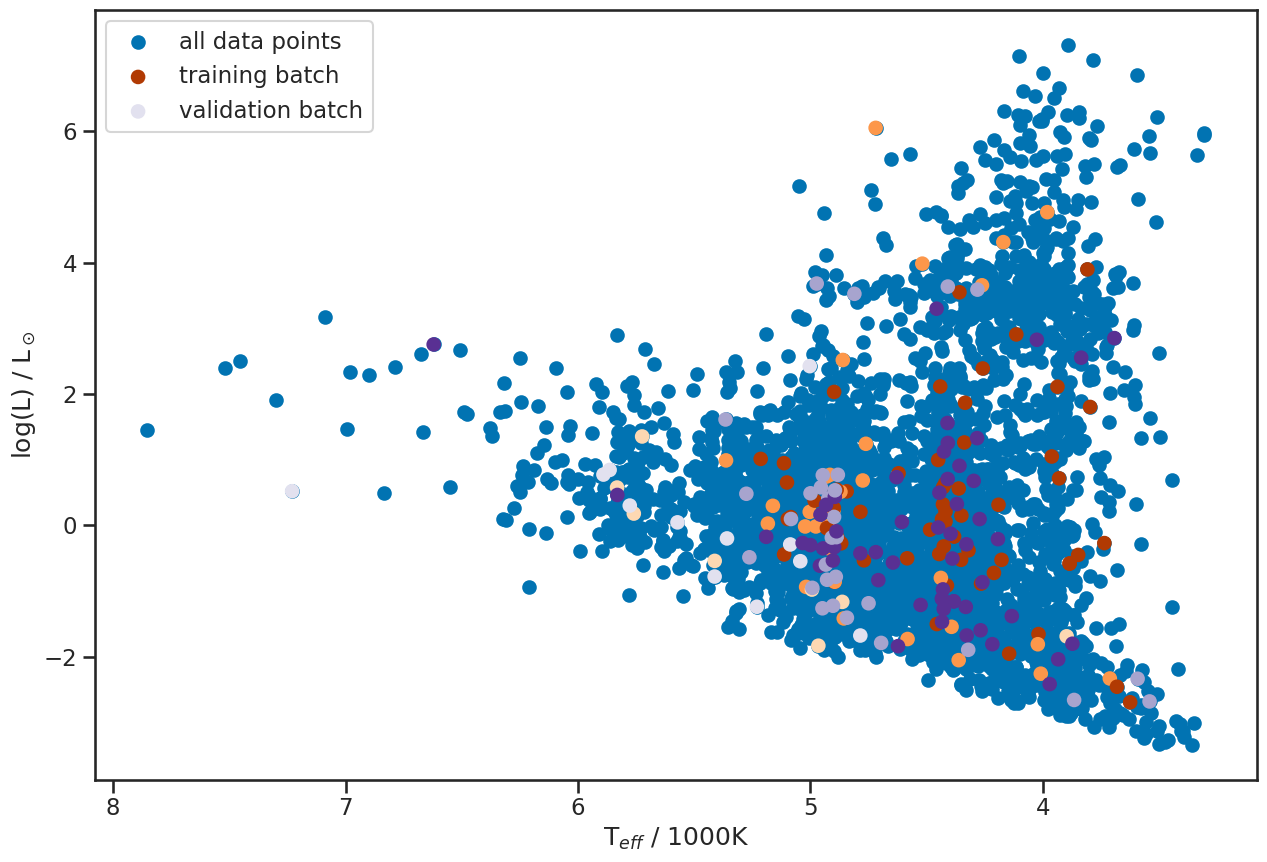

In [ ]:
#plot a batch of training and validation data on top of all the data
fig = plt.figure(figsize=(15,10))

plt.scatter(GCs_data_red[:,0], GCs_data_red[:,1], label=f'all data points')
train_batch, conds = get_training_data(train_data_stack)
plt.scatter(train_batch[:,0],train_batch[:,1],c=conds, cmap='Oranges',  label='training batch', vmin=10, vmax=13)
val_batch, conds = get_val_data(validation_data_stack)
plt.scatter(val_batch[:,0],val_batch[:,1], c=conds, cmap='Purples', label='validation batch', vmin=10, vmax=13)
plt.xlabel(r'T$_{\mathrm{eff}}$ / 1000K')
plt.ylabel(r'log(L / L$_\odot$)')

plt.legend()
plt.gca().invert_xaxis()
#plt.yscale('log')
plt.show()

We also want to check that the 1D distributions in effective temperature and log luminosity look easy for the flow to learn. The more Gaussian these look, the easier it will be for the flow. Harsh boundaries (e.g. luminosity must be greater than 0) or distributions with spikes will be harder for the flows to learn. This is why we first mapped these data and are using $T_{\mathrm{eff}}/1000$ and $\log(L)$ as our training data.

Text(0, 0.5, 'probability')

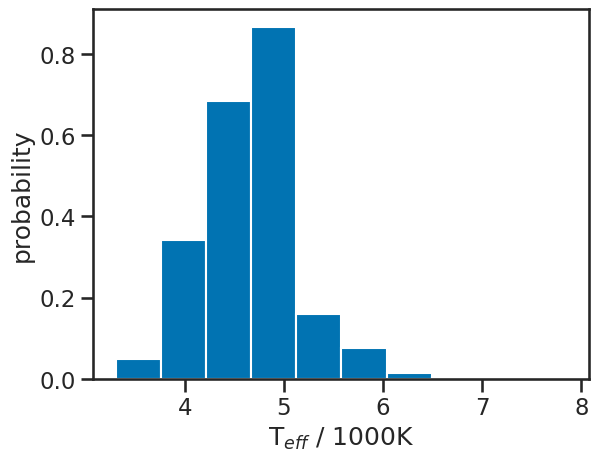

In [ ]:
#Checking the 1 distributions of the data - temperature
plt.hist(GCs_data_red[:,0], density=True)
plt.xlabel(r'T$_{\mathrm{eff}}$ / 1000K')
plt.ylabel('probability')

Text(0, 0.5, 'probability')

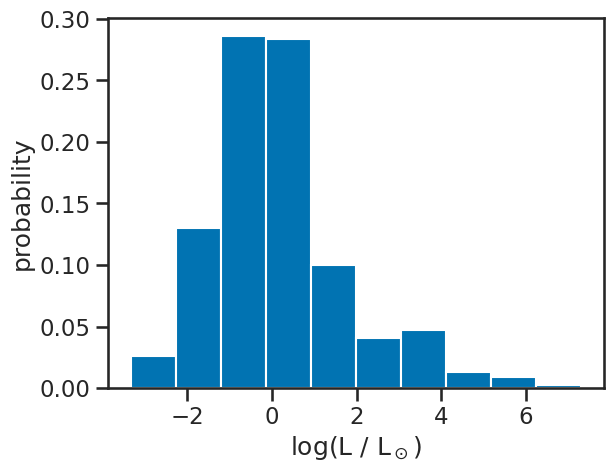

In [ ]:
#Checking the 1 distributions of the data - log luminosity
plt.hist(GCs_data_red[:,1], density=True)
plt.xlabel(r'log(L / L$_\odot$)')
plt.ylabel('probability')

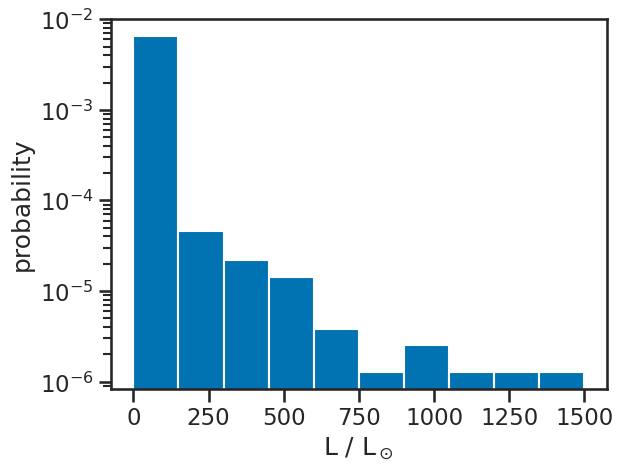

In [ ]:
#Checking the 1 distributions of the data - luminosity
#This distribution would be hard to learn - this is evidence why we want to learn log luminosity

plt.hist(np.exp(GCs_data_red[:,1]), density=True)
plt.xlabel(r'L / L$_\odot$')
plt.ylabel('probability')
plt.yscale('log')

## Setting up training

Now all our data is ready, we can initialise and start to train our flow. Our training loop will initialise the optimiser, loop over training epochs and batches, grab the training and validation data and calculate the KL. It determines which epoch of training produces the best flow with the best validation loss, and saves this flow.

In [ ]:
def trainval(flow, lr, epochs, batch_no, training_data, val_data):
        #set optimiser for flow, optimises the neural networks in the flow to minimise the loss (KL divergence)
        optimiser = torch.optim.Adam(flow.parameters(), lr=lr, weight_decay=0)

        n_epochs = epochs #number of iterations to train  - 1 epoch goes through through entire dataset
        n_batches = batch_no #number of batches of data in one iteration

        #initialize best flow model
        best_epoch = 0
        best_val_loss = np.inf

        #record network values and outputs in dictionary as training
        history = {'train': [], 'val': []}

        #training loop over epochs
        for n in range(n_epochs):
            train_loss = 0
            #set flow into training mode
            flow.train()

            #Loop over batches for stochastic gradient descent
            for _ in range(n_batches):
                #get a batch of training data with the conditional values
                x_train, x_conditional = get_training_data(training_data)
                #sets flow optimisers gradients to zero
                optimiser.zero_grad()
                #calculate the training loss function for flow as -log_prob
                loss = -(flow.log_prob(x_train, conditional=x_conditional)).mean()
                #computes gradient of flow network parameters
                loss.backward()
                #steps optimtiser down gradient of loss surface
                optimiser.step()
                #track flow losses
                train_loss += loss.item()

            #average and track loss
            train_loss /= n_batches
            history['train'].append(train_loss)

            # Validate
            with torch.no_grad(): #disables gradient caluclation
                #get a batch of validation data with the conditional values
                x_val, x_conditional_val = get_val_data(val_data)

                #evaluate flow parameters
                flow.eval()
                #calculate flow validation loss
                total_val_loss = - (flow.log_prob(x_val, conditional=x_conditional_val)).mean().numpy()
                #track validation loss
                history['val'].append(total_val_loss)

            #print history
            sys.stdout.write(
                    '\r Epoch: {} || Training loss: {} || Validation loss: {}'.format(
                    n+1, train_loss, total_val_loss))

            #copy the best flow model
            if total_val_loss < best_val_loss:
                best_epoch = n
                best_val_loss = total_val_loss
                best_model = copy.deepcopy(flow.state_dict())

        #save best model
        print(f'\n Best epoch: {best_epoch}')
        flow.load_state_dict(best_model)

        torch.save(best_model, f'gaia_flow_171024.pt')
        return flow, history

To initialise our flow, we use the Real Non Volume Preserving flow (or RealNVP). This is the formal name for the articture of an affine normalising flow, which scales and shifts the data with each learned transform.

To initialise it we give it the number of input parameters (2, effective temperature and log luminosity), number of conditionals (1, age), number of neurons in each transform, number of transforms, number of blocks.

We then train the flow specifying a learning rate, the number of epochs to train, and the number of batches of training data to grab for each epoch.

In [ ]:
no_params = 2
no_conds=1
batch_size =100

nflow = RealNVP(n_inputs = no_params, n_conditional_inputs= no_conds,
        n_neurons = 64, n_transforms = 6, n_blocks_per_transform = 2,
        linear_transform = None, batch_norm_between_transforms=True)
nflow, history = trainval(nflow, lr=1e-3, epochs=100, batches= 5, training_data=train_data_stack, \
                          validation_data= validation_data_stack)

 Epoch: 100 || Training loss: 1.9879655838012695 || Validation loss: 2.548793077468872
 Best epoch: 86


Plotting the loss of the above training:

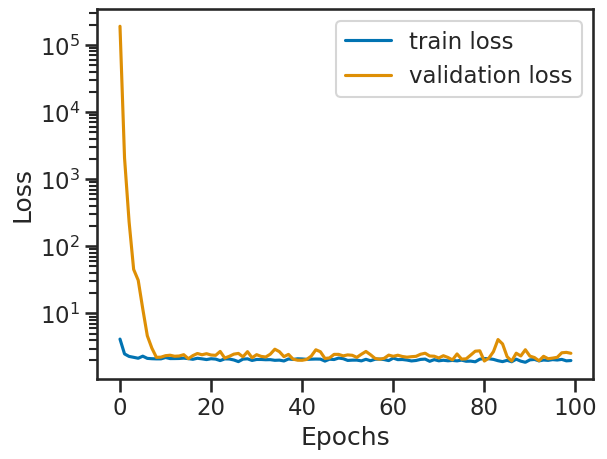

In [ ]:
plt.plot(history['train'], label='train loss')
plt.plot(history['val'], label='validation loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.yscale('log')

## Results from the Flow

We can now draw samples from the flow by supplying it with an array of conditional values. Now we can make the GCs have as many stars as we want by drawing more and more samples! Let's see how it can reproduce the training data for each GC:

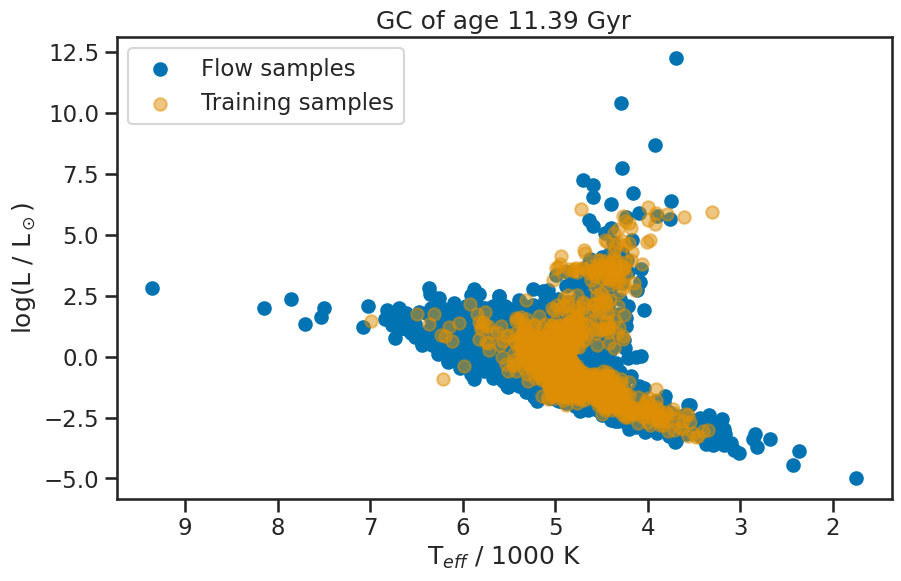

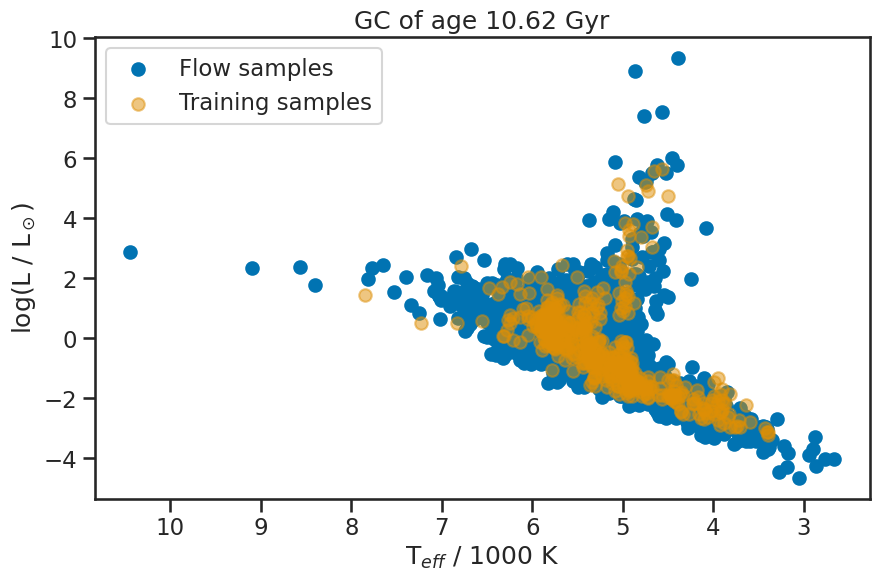

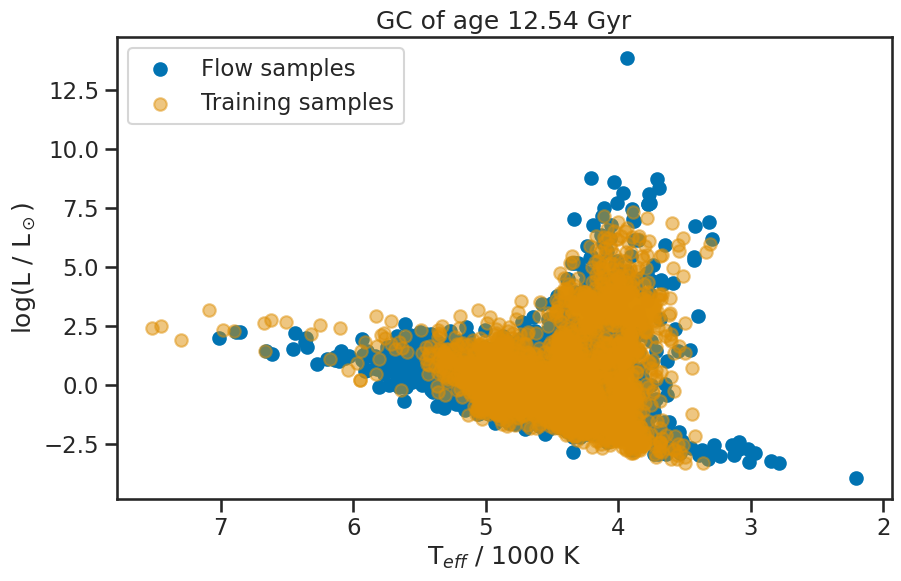

In [ ]:


for i in range(3):
  fig = plt.figure(figsize=(10,6))

  #for the conditionals to sample the flow, you need a torch float array with the shape [Nsamps,Nconds]
  #here we choose Nsamps=3000 so cond is an array of shape [3000,1] for each GC age in the training set
  age= GCs[i]['age(Gyr)']
  cond=np.repeat(np.array([[age]]), 3000, axis=0)

  #sampling the flow
  flow_samps=nflow.sample(3000, conditional=torch.from_numpy(cond.astype(np.float32))).detach().numpy()

  plt.scatter(flow_samps[:,0], flow_samps[:,1], label='Flow samples')

  #plot training data
  plt.scatter(data_red_all[i][:,0],data_red_all[i][:,1], label='Training samples', alpha=0.5)

  plt.xlabel(r'T$_{\mathrm{eff}}$ / 1000 K')
  plt.ylabel(r'log(L / L$_\odot$)')
  plt.title(f'GC of age {age} Gyr')
  plt.gca().invert_xaxis()
  plt.legend()
  plt.show()

Now, what if we wanted to know what the flow thought a GC of age 13.7 Gyr looked like, if there was such a thing? We can ask for this with the same conditional sampling; even though the flow doesn't know these data from training, it is able to extrapolate (and interpolate). Extrapolating is not recommended for real inference problems as we can't say whether the flow is behaving as we would expect outwith the conditional bounds of the training data

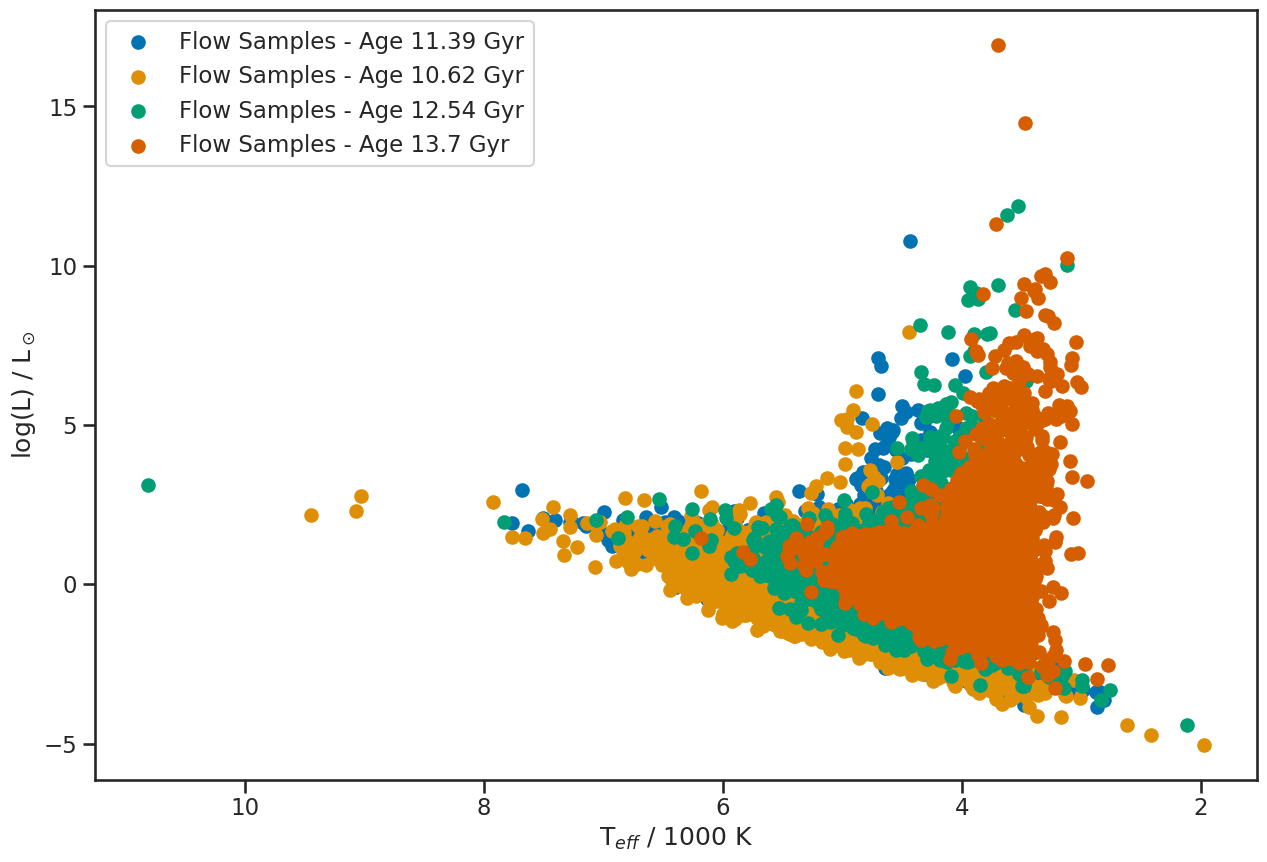

In [ ]:
fig = plt.figure(figsize=(15,10))

for i in range(3):
  cond=np.repeat(np.array([[GCs[i]['age(Gyr)']]]), 3000, axis=0)
  flow_samps=nflow.sample(3000, conditional=torch.from_numpy(cond.astype(np.float32))).detach().numpy()

  age= GCs[i]['age(Gyr)']
  plt.scatter(flow_samps[:,0], flow_samps[:,1], label=f'Flow Samples - Age {age} Gyr')


cond=np.repeat(np.array([[13.7]]), 3000, axis=0)
flow_samps=nflow.sample(3000, conditional=torch.from_numpy(cond.astype(np.float32))).detach().numpy()

plt.scatter(flow_samps[:,0], flow_samps[:,1],label=f'Flow Samples - Age 13.7 Gyr')
plt.xlabel(r'T$_{eff}$ / 1000 K')
plt.ylabel(r'log(L) / L$_\odot$')
plt.gca().invert_xaxis()
plt.legend()

Lastly, we can get the log probability of a star with any effective temperature and luminsity for a given age. We also need to include a Jacobian to transform this probability from the mapped space of $T_{\mathrm{eff}}/1000$ and $\log(L)$  to just that of $T_{\mathrm{eff}}$ and $L$.

In [ ]:
#T_eff and L of example star
sample=np.array([7000.,np.exp(10.)])

#the jacobian to add to the calculated log_prob from the flow
jac = [1/1000, 1/sample[1]]
jac = np.sum(np.log(np.abs(jac)))

#mapping this sample to T_eff/1000 and log(L), and making it a torch tensor as required
mapped_sample = np.array([sample[0]/1000, np.log(sample[1])])
mapped_sample=np.reshape(mapped_sample, (-1,2))
mapped_sample = torch.from_numpy(mapped_sample.astype(np.float32))

#reshaping the conditional, 8.5 Gyr
cond = np.array([8.5])
cond=np.reshape(cond, (-1,1))
cond=torch.from_numpy(cond.astype(np.float32))

#getting the log prob from the flow
log_prob = nflow.log_prob(mapped_sample, conditional=cond) + jac

In [ ]:
print(log_prob)

tensor([-70.8945], grad_fn=<AddBackward0>)
